<a href="https://colab.research.google.com/github/purvadanait/Final-Year-Project/blob/main/Crack%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
positive_dir = Path(r'/content/drive/My Drive/Positive')
negative_dir = Path(r'/content/drive/My Drive/Negative')

In [ ]:
!ls "/content/drive/My Drive/Positive"

^C


In [ ]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [ ]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")

all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,/content/drive/My Drive/Positive/09423.jpg,POSITIVE
1,/content/drive/My Drive/Positive/14126_1.jpg,POSITIVE
2,/content/drive/My Drive/Positive/10494_1.jpg,POSITIVE
3,/content/drive/My Drive/Positive/00235.jpg,POSITIVE
4,/content/drive/My Drive/Negative/05089.jpg,NEGATIVE
...,...,...
40045,/content/drive/My Drive/Positive/10627_1.jpg,POSITIVE
40046,/content/drive/My Drive/Negative/15379.jpg,NEGATIVE
40047,/content/drive/My Drive/Positive/08826.jpg,POSITIVE
40048,/content/drive/My Drive/Positive/14336_1.jpg,POSITIVE


In [ ]:
list(positive_dir.glob(r'*.jpg'))

[PosixPath('/content/drive/My Drive/Positive/10680_1.jpg'),
 PosixPath('/content/drive/My Drive/Positive/13934_1.jpg'),
 PosixPath('/content/drive/My Drive/Positive/10922_1.jpg'),
 PosixPath('/content/drive/My Drive/Positive/19794.jpg'),
 PosixPath('/content/drive/My Drive/Positive/12715_1.jpg'),
 PosixPath('/content/drive/My Drive/Positive/00023.jpg'),
 PosixPath('/content/drive/My Drive/Positive/10746_1.jpg'),
 PosixPath('/content/drive/My Drive/Positive/00208.jpg'),
 PosixPath('/content/drive/My Drive/Positive/18283_1.jpg'),
 PosixPath('/content/drive/My Drive/Positive/19423.jpg'),
 PosixPath('/content/drive/My Drive/Positive/02520.jpg'),
 PosixPath('/content/drive/My Drive/Positive/01560.jpg'),
 PosixPath('/content/drive/My Drive/Positive/13257_1.jpg'),
 PosixPath('/content/drive/My Drive/Positive/02276.jpg'),
 PosixPath('/content/drive/My Drive/Positive/11712_1.jpg'),
 PosixPath('/content/drive/My Drive/Positive/09528.jpg'),
 PosixPath('/content/drive/My Drive/Positive/06875.jpg')

In [ ]:
train_df, test_df = train_test_split(
    all_df.sample(6000, random_state=1),
    train_size=0.7,
    shuffle= True,
    random_state=1
)

In [ ]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 3360 validated image filenames belonging to 2 classes.
Found 840 validated image filenames belonging to 2 classes.
Found 1800 validated image filenames belonging to 2 classes.


In [ ]:
inputs = tf.keras.Input(shape=(120, 120, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 32)               0     

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
105/105 [==============================] - 940s 9s/step - loss: 0.6813 - accuracy: 0.5488 - val_loss: 0.6585 - val_accuracy: 0.5798
Epoch 2/100
105/105 [==============================] - 10s 93ms/step - loss: 0.6314 - accuracy: 0.6515 - val_loss: 0.5905 - val_accuracy: 0.8119
Epoch 3/100
105/105 [==============================] - 10s 92ms/step - loss: 0.5534 - accuracy: 0.7759 - val_loss: 0.5050 - val_accuracy: 0.8488
Epoch 4/100
105/105 [==============================] - 10s 91ms/step - loss: 0.4644 - accuracy: 0.8560 - val_loss: 0.4226 - val_accuracy: 0.8750
Epoch 5/100
105/105 [==============================] - 10s 96ms/step - loss: 0.3758 - accuracy: 0.9122 - val_loss: 0.3414 - val_accuracy: 0.9262
Epoch 6/100
105/105 [==============================] - 10s 93ms/step - loss: 0.3072 - accuracy: 0.9262 - val_loss: 0.2989 - val_accuracy: 0.8976
Epoch 7/100
105/105 [==============================] - 10s 91ms/step - loss: 0.2485 - accuracy: 0.9372 - val_loss: 0.2223 - val_acc

In [ ]:
fig = px.line(
    history.history,
    y=['loss', 'val_loss'],
    labels={'index': "Epoch", 'value': "Loss"},
    title="Training and Validation Loss Over Time"
)

fig.show()

In [ ]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.07568
Test Accuracy: 97.94%
57/57 [==============================] - 4s 68ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



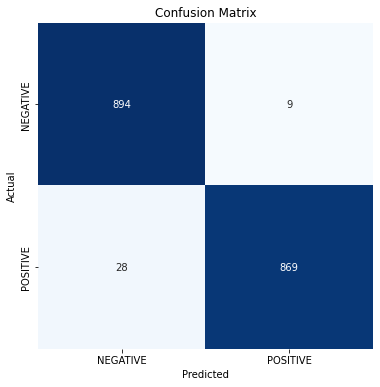

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98       903
    POSITIVE       0.99      0.97      0.98       897

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



In [ ]:
evaluate_model(model, test_data)